In [1]:
import json
import glob
from os import listdir
from os.path import isfile, join
import os.path as osp
import copy
import os
import pickle
from datetime import datetime
import random
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.filtering.log.attributes import attributes_filter
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv
from torch_geometric.nn import GATv2Conv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def nextplot(force=False):
    """Start a new plot.

    In a notebook (or if `force=True`), create a new figure. Otherwise (e.g, in
    IPython), clear the current figure.

    """
    inNotebook = "IPKernelApp" in get_ipython().config
    if force or inNotebook:
        plt.figure()  # this creates a new plot
    else:
        plt.clf()  # and this clears the current one

In [6]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\exp1\large-0.1-1.csv'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
validation_csv = label_csv.loc[label_csv['case_id'] > 9000]
validation_csv = validation_csv.loc[label_csv['case_id'] < 12001]
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
validation_csv.head(1)

,case_id,label
9000,9001,normal


In [7]:
# import final anomaly scores
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATl1h1nl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL1h1wl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL1h4nl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL1h4wl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL2h1nl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL2h1wl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL2h4nl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL2h4wl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL3h1nl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL3h1wl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL3h4nl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp1\models\GATL3h4wl_loss.pt'
anomaly_scores_path = r'D:\Final master thesis evaluation\exp2\bestgatmodl_test_loss.pt'

loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)

In [77]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, validation_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 248
[331, 0.9156626506024096, 0.7657430730478589, 0.8340192043895748, 0.9651424287856072, 0.9892431809450634, 0.9770442041358375, 0.9055317042627061]


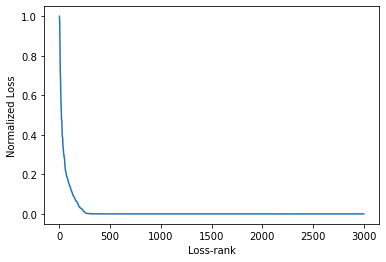

In [78]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(validation_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

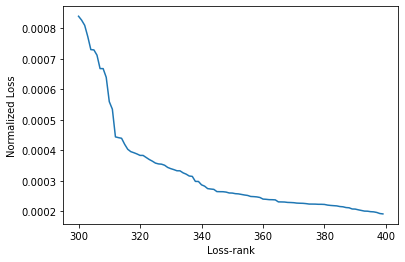

In [79]:
y2_axis = y_axis[300:400]
x_axis = np.arange(300,400)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

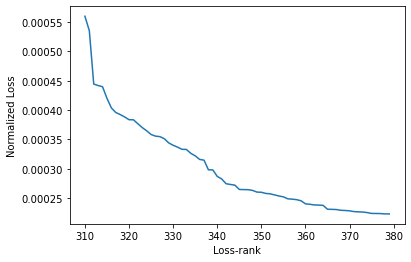

In [80]:
y2_axis = y_axis[310:380]
x_axis = np.arange(310,380)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [81]:
j= 310
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
            f1_score_on_normal, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[310, 0.9389067524115756, 0.7355163727959698, 0.824858757062147, 0.9609520267757531, 0.9927007299270073, 0.9765684051398338, 0.9007135811009903]
false positives 19


In [82]:
j= 310
search_more = True
while search_more:    
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if (false_positives/positives > 0.03):
        search_more = False
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    best_score = f1_score
    precision_on_normal = true_negatives/(true_negatives+false_negatives)
    recall_on_normal = true_negatives/(true_negatives+false_positives)
    f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
    macro_f1_score = (f1_score + f1_score_on_normal)/2
    best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                f1_score_on_normal, macro_f1_score]
    j += 1   
print(best_cut)

[310, 0.9389067524115756, 0.7355163727959698, 0.824858757062147, 0.9609520267757531, 0.9927007299270073, 0.9765684051398338, 0.9007135811009903]


In [8]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 284
[370, 0.9973045822102425, 0.8525345622119815, 0.919254658385093, 0.9756561430201598, 0.9996102883865939, 0.9874879692011549, 0.9533713137931239]


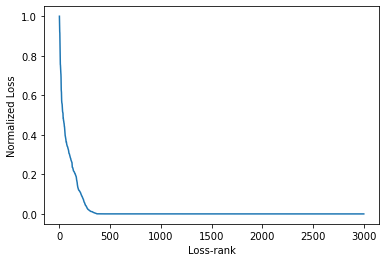

In [9]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(validation_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

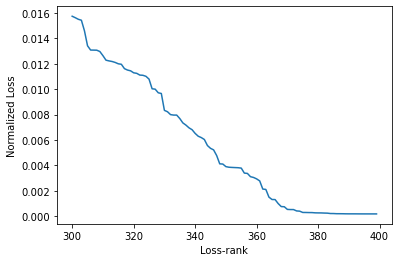

In [10]:
y2_axis = y_axis[300:400]
x_axis = np.arange(300,400)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

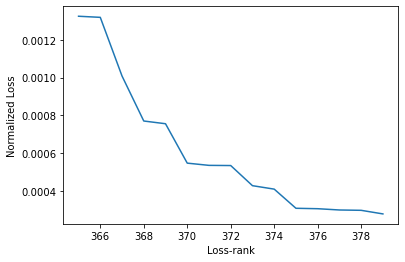

In [11]:
y2_axis = y_axis[365:380]
x_axis = np.arange(365,380)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [12]:
j= 374
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
            f1_score_on_normal, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[374, 0.9893333333333333, 0.8548387096774194, 0.9171817058096415, 0.976, 0.9984411535463756, 0.9870930456559429, 0.9521373757327922]
false positives 4


GAt Large 15% as the previous cell. Now large 30%

In [14]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\large-thirty\large-0.3-1.csv'
anomaly_scores_path = r'D:\Final master thesis evaluation\large-thirty\large30besthp_test_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
validation_csv = label_csv.loc[label_csv['case_id'] > 9000]
validation_csv = validation_csv.loc[label_csv['case_id'] < 12001]
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
validation_csv.head(1)

,case_id,label
9000,9001,normal


In [15]:
loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)

In [16]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 739
[785, 0.989821882951654, 0.8790960451977401, 0.9311789347695991, 0.9516711833785004, 0.9962174940898345, 0.9734349734349733, 0.9523069541022862]


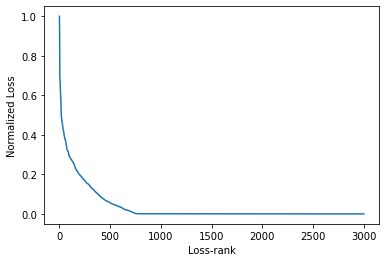

In [17]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(validation_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

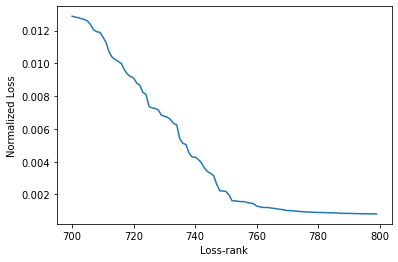

In [18]:
y2_axis = y_axis[700:800]
x_axis = np.arange(700,800)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

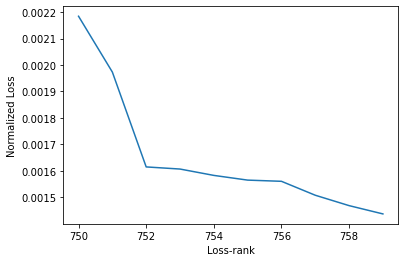

In [20]:
y2_axis = y_axis[750:760]
x_axis = np.arange(750,760)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [21]:
j= 752
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
            f1_score_on_normal, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[752, 0.99867197875166, 0.8497175141242937, 0.918192918192918, 0.940809968847352, 0.9995271867612293, 0.9692801467216874, 0.9437365324573027]
false positives 1


Gat Wide 30%

In [22]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\wide-thirty\wide-0.3-1.csv'
anomaly_scores_path = r'D:\Final master thesis evaluation\wide-thirty\wide30besthp_test_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
validation_csv = label_csv.loc[label_csv['case_id'] > 9000]
validation_csv = validation_csv.loc[label_csv['case_id'] < 12001]
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
validation_csv.head(1)

,case_id,label
9000,9001,"{'anomaly': 'Late', 'attr': {'shift_from': 0, ..."


In [23]:
loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)

In [24]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 752
[751, 1.0, 0.8025613660618997, 0.8904677323860272, 0.9177046263345195, 1.0, 0.957086522848527, 0.923777127617277]


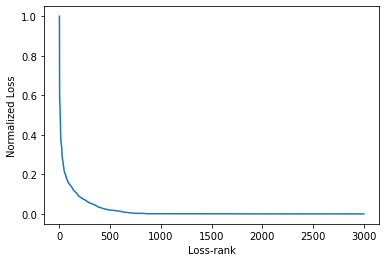

In [25]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(validation_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

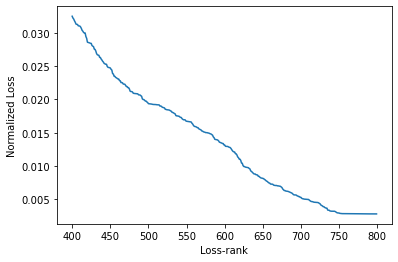

In [26]:
y2_axis = y_axis[400:800]
x_axis = np.arange(400,800)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

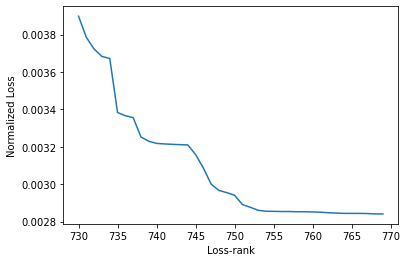

In [27]:
y2_axis = y_axis[730:770]
x_axis = np.arange(730,770)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [28]:
j= 745
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
            f1_score_on_normal, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[745, 1.0, 0.7961579509071505, 0.8865121806298277, 0.9152617568766637, 1.0, 0.95575631225388, 0.9211342464418539]
false positives 0


GAT small 30%

In [31]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\small-thirty\small-0.3-1.csv'
anomaly_scores_path = r'D:\Final master thesis evaluation\small-thirty\small30besthp_test_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
validation_csv = label_csv.loc[label_csv['case_id'] > 9000]
validation_csv = validation_csv.loc[label_csv['case_id'] < 12001]
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
validation_csv.head(1)

,case_id,label
9000,9001,normal


In [32]:
loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)

In [33]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 734
[733, 1.0, 0.8407789232531501, 0.9135034225264468, 0.9386584289496911, 1.0, 0.9683587525608923, 0.9409310875436696]


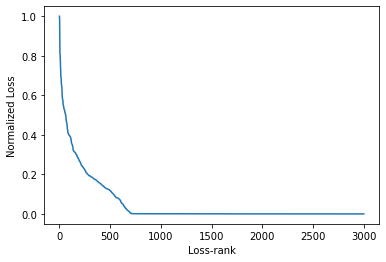

In [34]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(validation_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

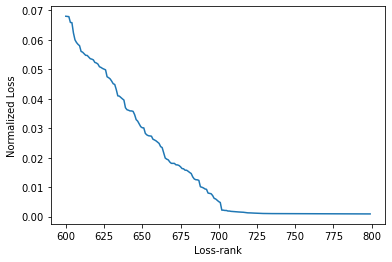

In [35]:
y2_axis = y_axis[600:800]
x_axis = np.arange(600,800)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

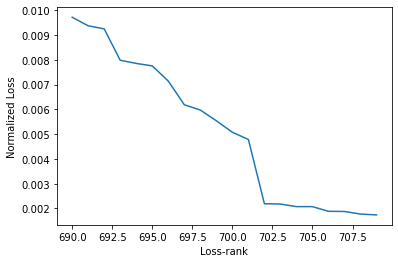

In [36]:
y2_axis = y_axis[690:710]
x_axis = np.arange(690,710)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [37]:
j= 701
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
            f1_score_on_normal, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[701, 1.0, 0.8041237113402062, 0.8914285714285715, 0.9255874673629243, 1.0, 0.9613559322033899, 0.9263922518159806]
false positives 0


In [38]:
j= 310
search_more = True
while search_more:    
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if (false_positives/positives > 0.03):
        search_more = False
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    best_score = f1_score
    precision_on_normal = true_negatives/(true_negatives+false_negatives)
    recall_on_normal = true_negatives/(true_negatives+false_positives)
    f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
    macro_f1_score = (f1_score + f1_score_on_normal)/2
    best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                f1_score_on_normal, macro_f1_score]
    j += 1   
print(best_cut)

[759, 0.9697368421052631, 0.8442153493699885, 0.9026331904470299, 0.9392857142857143, 0.9891866478608369, 0.9635905656056789, 0.9331118780263544]


GAT wide 15%

In [40]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\wide-fifteen\wide-0.1-1.csv'
anomaly_scores_path = r'D:\Final master thesis evaluation\wide-fifteen\wide15besthp_test_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
validation_csv = label_csv.loc[label_csv['case_id'] > 9000]
validation_csv = validation_csv.loc[label_csv['case_id'] < 12001]
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
validation_csv.head(1)

,case_id,label
9000,9001,normal


In [41]:
loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)

In [42]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 363
[391, 0.9821428571428571, 0.8536585365853658, 0.9134045077105575, 0.9746932515337423, 0.9972538250294233, 0.9858444832266822, 0.9496244954686198]


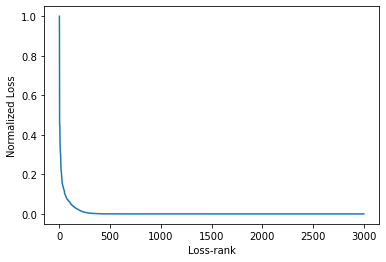

In [43]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(validation_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

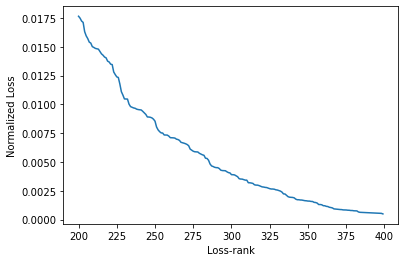

In [44]:
y2_axis = y_axis[200:400]
x_axis = np.arange(200,400)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

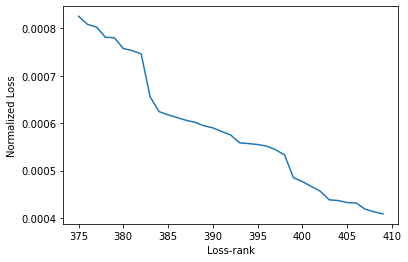

In [47]:
y2_axis = y_axis[375:410]
x_axis = np.arange(375,410)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [48]:
j= 395
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
            f1_score_on_normal, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[395, 0.9722222222222222, 0.8536585365853658, 0.9090909090909091, 0.9746543778801844, 0.9956845821890937, 0.9850572482049291, 0.947074078647919]
false positives 11


GAT huge 15%

In [49]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\huge-fifteen\huge-0.1-1.csv'
anomaly_scores_path = r'D:\Final master thesis evaluation\huge-fifteen\huge15besthp_test_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
validation_csv = label_csv.loc[label_csv['case_id'] > 9000]
validation_csv = validation_csv.loc[label_csv['case_id'] < 12001]
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
validation_csv.head(1)

,case_id,label
9000,9001,normal


In [50]:
loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)

In [51]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 132
[363, 0.967032967032967, 0.7822222222222223, 0.8648648648648648, 0.9628224582701063, 0.9952941176470588, 0.978789047435403, 0.9218269561501339]


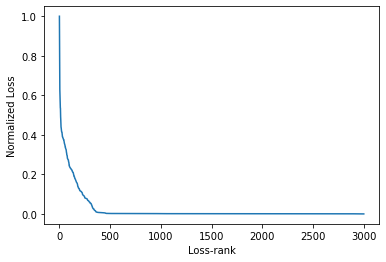

In [52]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(validation_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

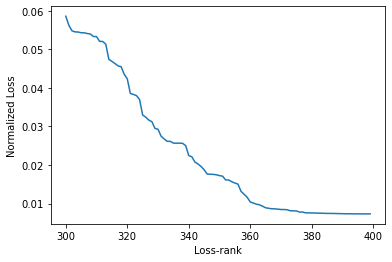

In [53]:
y2_axis = y_axis[300:400]
x_axis = np.arange(300,400)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

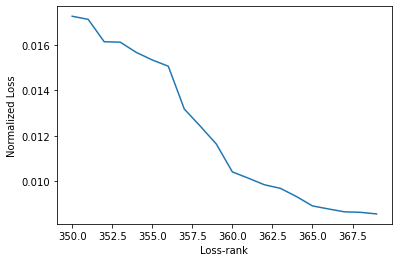

In [58]:
y2_axis = y_axis[350:370]
x_axis = np.arange(350,370)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [59]:
j= 365
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
            f1_score_on_normal, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[365, 0.9617486338797814, 0.7822222222222223, 0.8627450980392157, 0.9627942293090357, 0.9945098039215686, 0.9783950617283952, 0.9205700798838055]
false positives 14


In [56]:
j= 357
search_more = True
while search_more:    
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if (false_positives/positives > 0.03):
        search_more = False
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    best_score = f1_score
    precision_on_normal = true_negatives/(true_negatives+false_negatives)
    recall_on_normal = true_negatives/(true_negatives+false_positives)
    f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
    macro_f1_score = (f1_score + f1_score_on_normal)/2
    best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                f1_score_on_normal, macro_f1_score]
    j += 1   
print(best_cut)

[357, 0.9692737430167597, 0.7711111111111111, 0.8589108910891089, 0.9610143830431491, 0.995686274509804, 0.9780431432973806, 0.9184770171932448]


GAT small 15%

In [60]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\small-fifteen\small-0.1-1.csv'
anomaly_scores_path = r'D:\Final master thesis evaluation\small-fifteen\small15besthp_test_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
validation_csv = label_csv.loc[label_csv['case_id'] > 9000]
validation_csv = validation_csv.loc[label_csv['case_id'] < 12001]
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
validation_csv.head(1)

,case_id,label
9000,9001,normal


In [61]:
loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)

In [62]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 385
[386, 0.9974160206718347, 0.8301075268817204, 0.9061032863849765, 0.969766551856104, 0.9996055226824457, 0.9844599844599843, 0.9452816354224804]


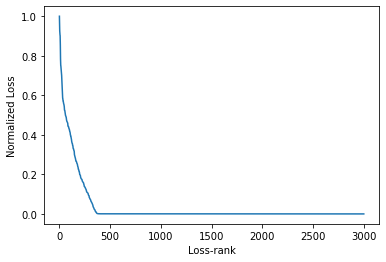

In [63]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(validation_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

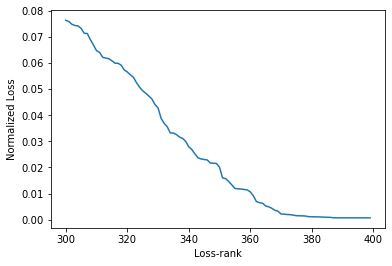

In [64]:
y2_axis = y_axis[300:400]
x_axis = np.arange(300,400)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

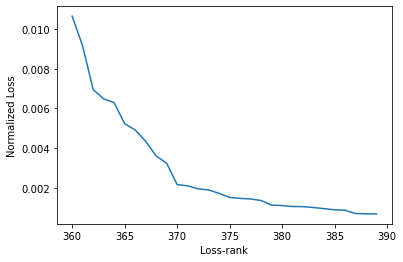

In [65]:
y2_axis = y_axis[360:390]
x_axis = np.arange(360,390)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [67]:
j= 378
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
            f1_score_on_normal, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[378, 1.0, 0.8150537634408602, 0.8981042654028437, 0.9671880961465089, 1.0, 0.9833204034134988, 0.9407123344081713]
false positives 0


### GAT Large, wide, huge, small 5, 1%

In [417]:
# import the truth label vactor
truth_label_path = r'D:\Final master thesis evaluation\small-one\small-0.0-1.csv'
anomaly_scores_path = r'D:\Final master thesis evaluation\small-one\small1besthp_test_loss.pt'
label_csv = pd.read_csv(truth_label_path)
label_csv.drop("Unnamed: 0", axis=1, inplace=True)
label_csv["case_id"] = pd.to_numeric(label_csv["case_id"])
label_csv.case_id.astype(str).astype(int)
label_csv.label.astype(str)
#label_csv.dtypes
validation_csv = label_csv.loc[label_csv['case_id'] > 9000]
validation_csv = validation_csv.loc[label_csv['case_id'] < 12001]
test_csv =  label_csv.loc[label_csv['case_id'] > 12000]
validation_csv.head(1)

,case_id,label
9000,9001,normal


In [418]:
loss_df = pd.read_pickle(anomaly_scores_path)
# normalize anomaly scores
normalized_loss_df = loss_df.copy()
normalized_loss_df['Loss'] = (normalized_loss_df['Loss'] - normalized_loss_df['Loss'].min()) / (normalized_loss_df['Loss'].max() - normalized_loss_df['Loss'].min())
# sort the normalized scores
sorted_loss = normalized_loss_df.sort_values(by=['Loss'], ascending = False, ignore_index = True)

In [419]:
loss_df["case_id"] = pd.to_numeric(loss_df["case_id"])
result = pd.merge(loss_df, test_csv, on=["case_id"])
sorted_result = result.sort_values(by=['Loss'], ascending = False, ignore_index = True)
sorted_list = sorted_result['label'].tolist()
predictions = []
for j in range (len(sorted_list)):
    if sorted_list[j] == 'normal':
        predictions.append(0)
    else:
        predictions.append(1)
prediction_array = np.array(predictions)
best_score = 0
first_fp = True
for j in range (len(sorted_list)):
    current_alarms = prediction_array[0:j+1]
    current_normals = prediction_array[j+1:]
    positives = j+1
    true_positives = np.sum(current_alarms)
    false_positives = positives - true_positives
    if first_fp and false_positives > 0:
        first_fp = False
        print('first false positive:', j)
    negatives = 3000 - positives
    false_negatives = np.sum(current_normals)
    true_negatives = negatives - false_negatives
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1_score = 2*precision*recall/(precision+recall)
    if f1_score > best_score:
        best_score = f1_score
        precision_on_normal = true_negatives/(true_negatives+false_negatives)
        recall_on_normal = true_negatives/(true_negatives+false_positives)
        f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
        macro_f1_score = (f1_score + f1_score_on_normal)/2
        best_cut = [j, precision, recall, f1_score, precision_on_normal, recall_on_normal,
                    f1_score_on_normal, macro_f1_score]    
print(best_cut)

first false positive: 23
[22, 1.0, 0.8846153846153846, 0.9387755102040816, 0.9989922741014444, 1.0, 0.9994958830448664, 0.969135696624474]


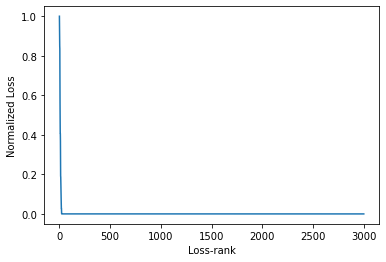

In [420]:
loss_list = sorted_loss['Loss'].tolist()
y_axis = np.array(loss_list)
x_axis = np.arange(len(validation_csv))
nextplot()
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y_axis)
plt.show()

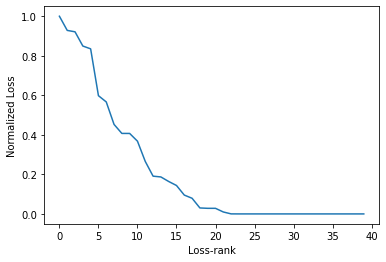

In [421]:
y2_axis = y_axis[0:40]
x_axis = np.arange(0,40)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

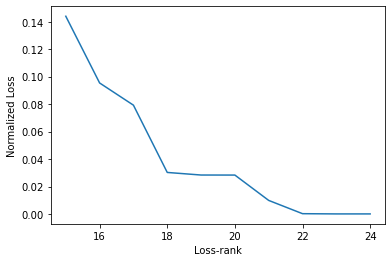

In [422]:
y2_axis = y_axis[15:25]
x_axis = np.arange(15,25)
plt.xlabel("Loss-rank")
plt.ylabel("Normalized Loss")
plt.plot(x_axis, y2_axis)
plt.show()

In [423]:
j= 22
current_alarms = prediction_array[0:j+1]
current_normals = prediction_array[j+1:]
positives = j+1
true_positives = np.sum(current_alarms)
false_positives = positives - true_positives
negatives = 3000 - positives
false_negatives = np.sum(current_normals)
true_negatives = negatives - false_negatives
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
f1_score = 2*precision*recall/(precision+recall)
fhalf_score = 5/4*precision*recall/(1/4*precision+recall)
best_score = f1_score
precision_on_normal = true_negatives/(true_negatives+false_negatives)
recall_on_normal = true_negatives/(true_negatives+false_positives)
f1_score_on_normal = 2*precision_on_normal*recall_on_normal/(precision_on_normal+recall_on_normal)
macro_f1_score = (f1_score + f1_score_on_normal)/2
best_cut = [j, precision, recall, f1_score, fhalf_score, macro_f1_score]    
print(best_cut)
print('false positives', false_positives)

[22, 1.0, 0.8846153846153846, 0.9387755102040816, 0.9745762711864407, 0.969135696624474]
false positives 0
